In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
def printDS(x):
    print(list(x.as_numpy_iterator())[:5])

In [3]:
imgs_path = tf.data.Dataset.list_files('./Data/ACGPN_traindata/train_img/*.jpg', shuffle=False)
imgs_masks_path = tf.data.Dataset.list_files('./Data/ACGPN_traindata/train_label/*.png', shuffle=False)

imgs_path_ds = tf.data.Dataset.zip((imgs_path, imgs_masks_path))

In [4]:
list(imgs_path_ds.take(5).as_numpy_iterator())

[(b'./Data/ACGPN_traindata/train_img/000003_0.jpg',
  b'./Data/ACGPN_traindata/train_label/000003_0.png'),
 (b'./Data/ACGPN_traindata/train_img/000004_0.jpg',
  b'./Data/ACGPN_traindata/train_label/000004_0.png'),
 (b'./Data/ACGPN_traindata/train_img/000005_0.jpg',
  b'./Data/ACGPN_traindata/train_label/000005_0.png'),
 (b'./Data/ACGPN_traindata/train_img/000006_0.jpg',
  b'./Data/ACGPN_traindata/train_label/000006_0.png'),
 (b'./Data/ACGPN_traindata/train_img/000007_0.jpg',
  b'./Data/ACGPN_traindata/train_label/000007_0.png')]

In [44]:
# imgs = [keras.preprocessing.image.load_img(x, target_size=(256, 256)) for x in imgs_path]
# imgs = tf.data.Dataset.from_tensor_slices(imgs)

# imgs_masks = [keras.preprocessing.image.load_img(x, target_size=(256, 256)) for x in imgs_masks_path]
# imgs_masks = tf.data.Dataset.from_tensor_slices(imgs_masks)

def process(x, y):
    img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (256, 256))
    img = tf.floor(img)
    img = tf.cast(img, 'uint8')

    mask = tf.io.read_file(y)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.floor(mask)
    mask = tf.cast(mask, 'uint8')
    return img, mask

img_ds = imgs_path_ds.map(lambda x, y: process(x, y))

In [ ]:
img_ds = img_ds.batch(64)

<TakeDataset shapes: ((256, 256, None), (256, 256, 1)), types: (tf.uint8, tf.uint8)>
(256, 256, 3)
(256, 256, 1)


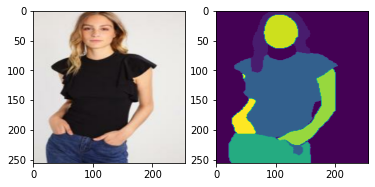

In [45]:
# a, b = list(img_ds.shuffle(100).take(1).as_numpy_iterator())[0]
a, b = list(img_ds.take(1).as_numpy_iterator())[0]
print(img_ds.take(1))

fig, ax = plt.subplots(ncols=2)
# i = np.random.randint(0, 64)
print(a.shape)
print(b.shape)
ax[0].imshow(a)
ax[1].imshow(b)

In [14]:
def downSample(inp, filters, kernel=(3, 3), strides=1, padding='same', activation='relu'):
    conv_1 = layers.Conv2D(filters, kernel, strides, padding, activation=activation)(inp)
    conv_2 = layers.Conv2D(filters, kernel, strides, padding, activation=activation)(conv_1)
    maxpool = layers.MaxPool2D((2, 2))(conv_2)
    
    return conv_2, maxpool

def upSample(inp, cat, filters, kernel=(3, 3), strides=1, padding='same', activation='relu'):
    upSampled = layers.Conv2DTranspose(filters, kernel, (2, 2), padding, activation=activation)(inp)
    conct = layers.Concatenate()([upSampled, cat])
    conv_1 = layers.Conv2D(filters, kernel, strides, padding, activation=activation)(conct)
    conv_2 = layers.Conv2D(filters, kernel, strides, padding, activation=activation)(conv_1)
    
    return conv_2

def downSampleWOMaxPool(inp, filters, kernel=(3, 3), strides=1, padding='same', activation='relu'):
    conv_1 = layers.Conv2D(filters, kernel, strides, padding, activation=activation)(inp)
    conv_2 = layers.Conv2D(filters, kernel, strides, padding, activation=activation)(conv_1)
    
    return conv_2

In [15]:
def getUNet():
    
    filters = [
        64,
        128,
        256,
        512,
        1024
    ]
    
    # 256x256
    inp = layers.Input((256, 256, 3))
    
    # 256x256 -> 128x128
    c1, mp1 = downSample(inp, filters[0])
    
    # 128x128 -> 64x64
    c2, mp2 = downSample(mp1, filters[1])
    
    # 64x64 -> 32x32
    c3, mp3 = downSample(mp2, filters[2])
    
    # 32x32 -> 16x16
    c4, mp4 = downSample(mp3, filters[3])
    
    # 16 mid layer
    c5 = downSampleWOMaxPool(mp4, filters[4])
    
    # 16x16 -> 32x32
    us1 = upSample(c5, c4, filters[3])
    
    # 32x32 -> 64x64
    us2 = upSample(us1, c3, filters[2])
    
    # 64x64 -> 128x128
    us3 = upSample(us2, c2, filters[1])
    
    # 128x128 -> 256x256
    us4 = upSample(us3, c1, filters[0])
    
    out = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(us4)
    
    return models.Model(inp, out)

In [46]:
model = getUNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
# model.summary()

In [47]:
# img_ds = img_ds.unbatch()
sharded_img_ds = img_ds.shard(3, 0)
sharded_img_ds_batched = sharded_img_ds.batch(32)

sharded_img_ds1 = img_ds.shard(600, 1)
sharded_img_ds1_batched = sharded_img_ds1.batch(32)

In [48]:
history = model.fit(sharded_img_ds_batched, epochs=25)

Train for 149 steps
Epoch 1/25
149/149 [==============================] - 75s 502ms/step - loss: nan - acc: 0.5161
Epoch 2/25
149/149 [==============================] - 73s 487ms/step - loss: nan - acc: 0.5611
Epoch 3/25
149/149 [==============================] - 73s 490ms/step - loss: nan - acc: 0.5611
Epoch 4/25
 15/149 [==>...........................] - ETA: 1:03 - loss: nan - acc: 0.5575

KeyboardInterrupt: 

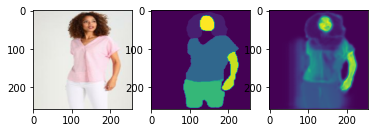

In [19]:
a, b = list(img_ds.take(5).as_numpy_iterator())[4]

x = np.array(a)
x = np.expand_dims(x, axis=0)
# print(x.shape)
ot = model.predict(x)

fig, ax = plt.subplots(ncols=3)
ax[0].imshow(a)
ax[1].imshow(b)
ax[2].imshow(ot[0])

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_weights.h5")
print("Saved model to disk")

## https://github.com/NiveditJain/Simultaneous-Optimisation-of-Image-Quality-Improvement-and-Text-Content-Extraction-from-scanned-docu/blob/master/Models/SRCNN%20modified%20loss%20with%20regularisation/train.py